Generative Adversarial Networks (GANs)
======
This code implements a Deep Convolutional GAN (DCGAN), a GAN with only convolutional layers in the encoder and decoder.

Based on [[this notebook]](https://github.com/smartgeometry-ucl/dl4g/blob/master/gan.ipynb).

In [1]:
import sys
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils

import matplotlib.pyplot as plt

Parameter Settings
-------------------


In [2]:
latent_dims = 10
num_epochs = 3
batch_size = 128
learning_rate = 2e-4
use_gpu = False

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. The images are normalized and centerd around 0, which gives a slight performance boost during training. We create both a training set and a test set.

In [3]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(data_utils.Subset(train_dataset, range(5000)), batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(data_utils.Subset(test_dataset, range(500)), batch_size=batch_size, shuffle=True)

torch.Size([1, 28, 28])


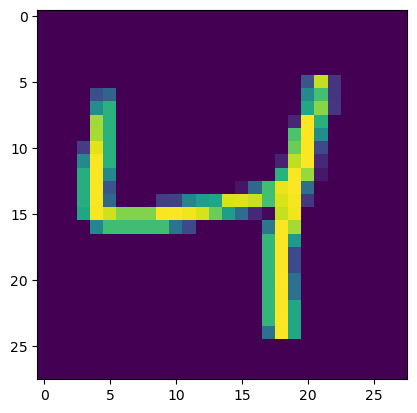

In [4]:
plt.imshow(train_dataset[2][0][0])
print(train_dataset[2][0].shape)

GAN Definition
-----------------------
We use a convolutional generator and discriminator, which generally gives better performance than fully connected versions that have the same number of parameters.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

In [5]:
class Generator(nn.Module):
    def __init__(self, d=16):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(in_channels = 100, out_channels = d, kernel_size = 4)
        self.deconv1_bn = nn.BatchNorm2d(d)
        self.deconv2 = nn.ConvTranspose2d(in_channels = d, out_channels = 1, kernel_size = 4, stride = 4)

    def forward(self, input):
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = torch.tanh(self.deconv2(x, output_size = (input.size()[0], 1, 28, 28)))

        return x

class Discriminator(nn.Module):
    def __init__(self, d=16):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = d, kernel_size = 4, stride = 2, padding = 1)
        self.conv1_bn = nn.BatchNorm2d(d)
        self.conv2 = nn.Conv2d(in_channels = d, out_channels = 1, kernel_size = 4, stride = 1, padding = 0)

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(121, 1)

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = self.flatten(self.conv2(x))
        x = torch.sigmoid(self.linear(x))

        return x

generator = Generator()
discriminator = Discriminator()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))

Number of parameters for generator: 25905 and discriminator: 683


Train GAN
--------


In [6]:
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# set to training mode
generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0

    for image_batch, _ in train_dataloader:

        # get dataset image and create real and fake labels for use in the loss
        image_batch = image_batch.to(device)
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)

        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), 100, 4, 4, device=device)
        fake_image_batch = generator(latent)

        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))

        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()

        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1

    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %
          (epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1]))

Training ...
Epoch [1 / 3] average loss generator vs. discrim.: 0.726445 vs. 0.599557
Epoch [2 / 3] average loss generator vs. discrim.: 0.833747 vs. 0.353462
Epoch [3 / 3] average loss generator vs. discrim.: 1.060059 vs. 0.238916


Plot Training Curves
--------------------

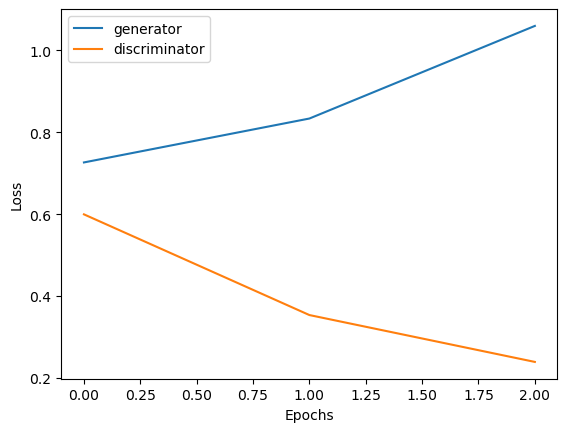

In [7]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(gen_loss_avg, label='generator')
plt.plot(disc_loss_avg, label='discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Sample Latent Vector from Prior (GAN as Generator)
-------------------------------------------------

GANs usually generate higher-quality results than VAEs or plain Autoencoders, since the distribution of generated digits is more focused on the modes of the real data distribution (see tutorial slides). However, they are harder to train and don't have an encoder, which means the inference of a latent code from a given image is not possible.

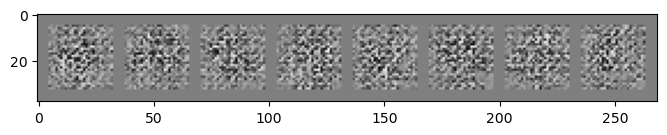

In [8]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():

    # sample latent vectors from the standard normal distribution
    latent = torch.randn(image_batch.size(0), 100, 4, 4, device=device)
    fake_image_batch = generator(latent)
    fake_image_batch = fake_image_batch.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(fake_image_batch.data[:100],10,5))
    plt.show()

Interpolate in Latent Space
----------------------------

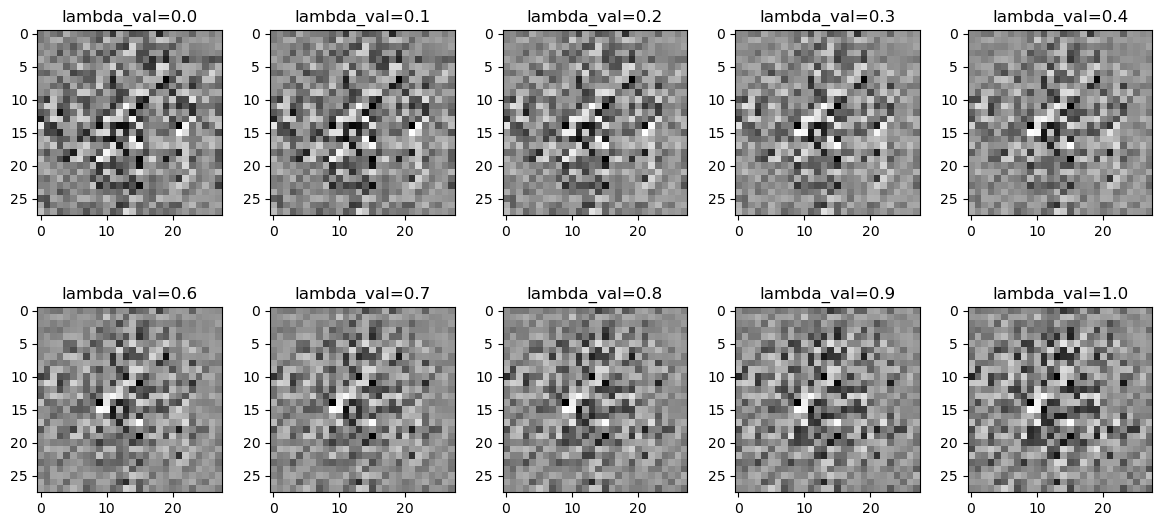

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1 * latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn(1, 100, 4, 4, device=device)
latent_2 = torch.randn(1, 100, 4, 4, device=device)

# interpolation lambdas
lambda_range=np.linspace(0, 1, 10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), generator, latent_1, latent_2)

    inter_image = to_img(inter_image)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show()